In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import torchvision.io

import matplotlib.pyplot as plt
import numpy as np
import math


In [2]:
data = {}
for subdir, dirs, files in os.walk("dataset/train"):
    for file in files:
        path = f"{subdir}/{file}"
        # print(path)
        if ".png" not in path:
            continue
        img = torchvision.io.read_image(path)
        if subdir in data:
            data[subdir].append(img)
        else:
            data[subdir] = [img]


In [3]:
t_data = []
for i in range(685):
    temp = (data['dataset/train\high_res'][i], data['dataset/train\low_res'][i])
    t_data.append(temp)


In [4]:
train_loader = torch.utils.data.DataLoader(t_data, batch_size=20, shuffle=True)

In [5]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=4, out_channels=16,
                  kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=11, stride=1, padding=5),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.f1 = nn.Linear(16*16*128, 196)
    self.f2 = nn.Linear(196, 49)
    self.f3 = nn.Linear(49, 7)
    self.flatten = nn.Flatten(start_dim=1)
  def forward(self, image):
    out = self.layer1(image)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.flatten(out)
    out = F.relu(self.f1(out))
    # out = F.sigmoid(self.f1(out))
    # out = F.tanh(self.f1(out))
    out = F.relu(self.f2(out))
    # out = F.sigmoid(self.f2(out))
    # out = F.tanh(self.f2(out))
    out = F.relu(self.f3(out))
    # out = F.sigmoid(self.f3(out))
    # out = F.tanh(self.f3(out))
    return out

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.f1 = nn.Linear(7, 49)
    self.f2 = nn.Linear(49, 196)
    self.f3 = nn.Linear(196, 16*16*128)
    self.unflatten = nn.Unflatten(1, torch.Size([128, 16, 16]))
    self.layer1 = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=11, stride=1, padding=5),
        )
    self.layer2 = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7, stride=1, padding=3),
        )
    self.layer3 = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=2),
        )
    self.layer4 = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Sigmoid(),
        nn.BatchNorm2d(16),
        nn.ConvTranspose2d(in_channels=16, out_channels=4, kernel_size=3, stride=1, padding=1),
        )

  def forward(self, z):
    out = F.relu(self.f1(z))
    # out = F.sigmoid(self.f1(out))
    # out = F.tanh(self.f1(out))
    out = F.relu(self.f2(out))
    # out = F.sigmoid(self.f2(out))
    # out = F.tanh(self.f2(out))
    out = F.relu(self.f3(out))
    # out = F.sigmoid(self.f3(out))
    # out = F.tanh(self.f3(out))
    out = self.unflatten(out) 
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out
 
class Autoncoder(nn.Module):
  def __init__(self):
    super(Autoncoder,self).__init__()
    self.encoder = Encoder()
    self.Decoder = Decoder()

  def forward(self, image):
    z = self.encoder(image)
    out =  self.Decoder(z)
    return out


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
    
      for low_res, high_res in train_loader:
          low_res = low_res.float().to(device)
          high_res = high_res.float().to(device)

          img_recon = model(low_res)
          # print(img_recon.shape)
          loss = loss_fn(img_recon, high_res)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg


In [8]:

learning_rate = 0.1
autoencoder = Autoncoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
# autoencoder.train()
loss_values = train(autoencoder, train_loader,20, loss)

Epoch [1 / 20] average reconstruction error: 10700.403544
Epoch [2 / 20] average reconstruction error: 2920.264837
Epoch [3 / 20] average reconstruction error: 2819.675523
Epoch [4 / 20] average reconstruction error: 2706.964376
Epoch [5 / 20] average reconstruction error: 2775.523162
Epoch [6 / 20] average reconstruction error: 2732.295710
Epoch [7 / 20] average reconstruction error: 2676.713658
Epoch [8 / 20] average reconstruction error: 2734.401011
Epoch [9 / 20] average reconstruction error: 2722.660686
Epoch [10 / 20] average reconstruction error: 2699.660003
Epoch [11 / 20] average reconstruction error: 2701.260805
Epoch [12 / 20] average reconstruction error: 2664.320783
Epoch [13 / 20] average reconstruction error: 2645.560003
Epoch [14 / 20] average reconstruction error: 2771.213323
Epoch [15 / 20] average reconstruction error: 2736.125160
Epoch [16 / 20] average reconstruction error: 2666.109780
Epoch [17 / 20] average reconstruction error: 2657.626611
Epoch [18 / 20] averag

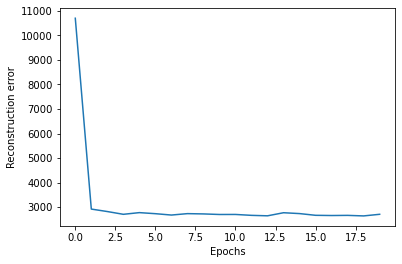

In [9]:
fig = plt.figure()
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [10]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out,10,5)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

entro
imagen leida


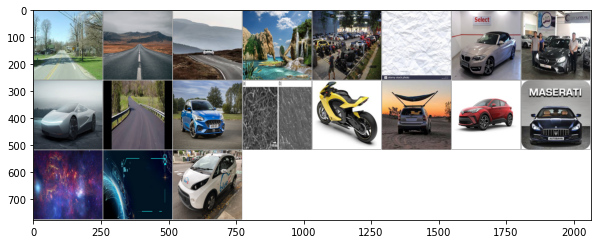

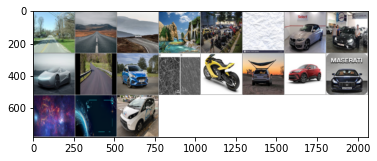

In [20]:
with torch.no_grad():
  print("entro")
  iterator = iter(train_loader)
  image1,label = iterator.next()
  
  
  print("imagen leida")
  fig, ax = plt.subplots(figsize=(10, 10))
  Show_Weight(image1[1:64])
  Show_Weight(label[1:64])
  plt.show()

imagen Real


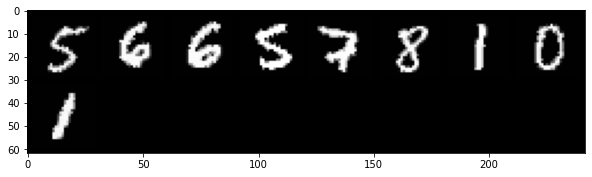

imagen con ruido


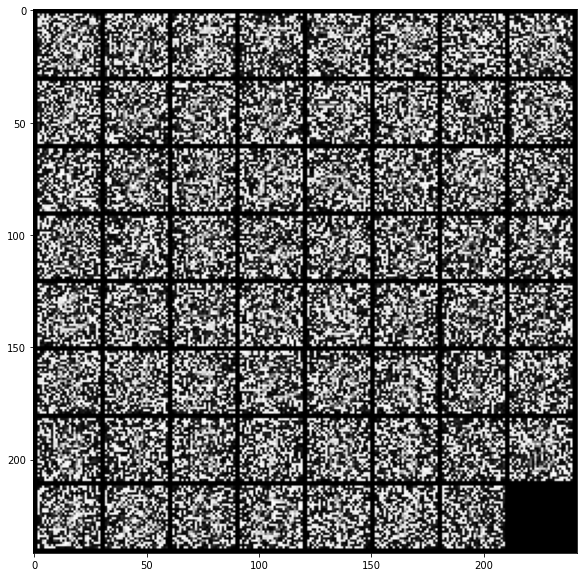

In [ ]:

image1,label = iterator.next()
  

print("imagen Real")
fig, ax = plt.subplots(figsize=(10, 10))
Show_Weight(image1[1:10])
plt.show()

image = image1 + torch.randn(image1.size())*0.09 + 0.01 
  
 
print("imagen con ruido")
image = image.view(image.size(0),1,28,28)
fig, ax = plt.subplots(figsize=(10, 10))
Show_Weight(image[1:64])
plt.show()

torch.Size([64, 7])
imagen reconstruida


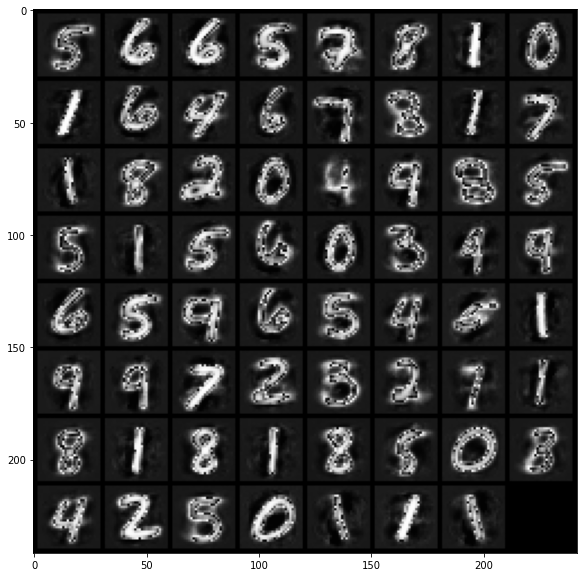

imagen Real


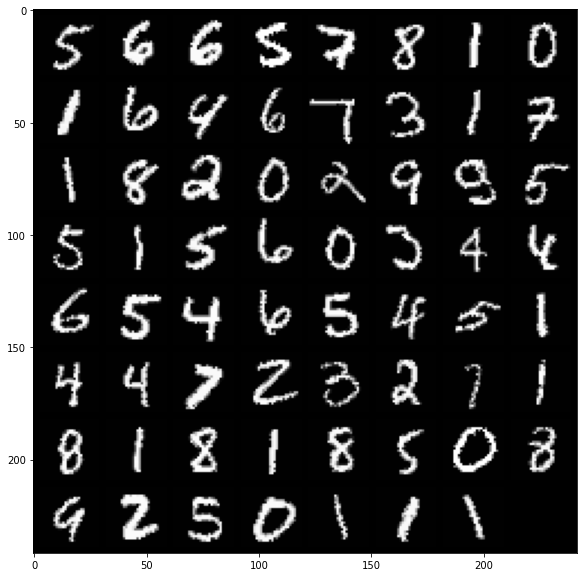

In [ ]:

# 4 6 9 5 4 2 8 8 9
image = image.to(device)
image = image.view(image.size(0),-1)

salida = autoencoder(image)
salida = salida.view(salida.size(0),1,28,28)
  

z = autoencoder.encoder(image)
print(z.shape)

print("imagen reconstruida")
fig, ax = plt.subplots(figsize=(10, 10))
Show_Weight(salida[1:64])
plt.show()

print("imagen Real")
fig, ax = plt.subplots(figsize=(10, 10))
Show_Weight(image1[1:64])
plt.show()

In [ ]:
# 4 6 9 5 4 2 8 8 9